In [23]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Number of Fire images: 25018
Number of No_Fire images: 14357


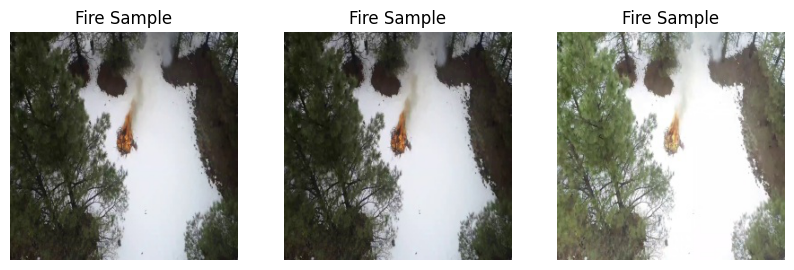

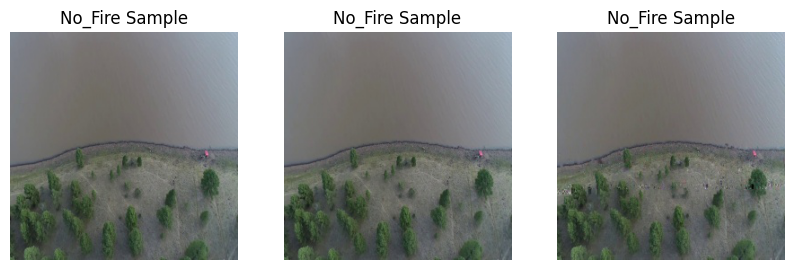

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Directories for Fire and No_Fire images
fire_dir = 'Training/Fire'
no_fire_dir = 'Training/No_Fire'

# Count images in each category
num_fire_images = len(os.listdir(fire_dir))
num_no_fire_images = len(os.listdir(no_fire_dir))
print(f"Number of Fire images: {num_fire_images}")
print(f"Number of No_Fire images: {num_no_fire_images}")

# Display a few sample images from each class
def display_sample_images(class_dir, class_name, num_images=3):
    images = os.listdir(class_dir)[:num_images]
    plt.figure(figsize=(10, 3))
    for i, image_name in enumerate(images):
        img_path = os.path.join(class_dir, image_name)
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"{class_name} Sample")
        plt.axis('off')
    plt.show()

display_sample_images(fire_dir, 'Fire')
display_sample_images(no_fire_dir, 'No_Fire')

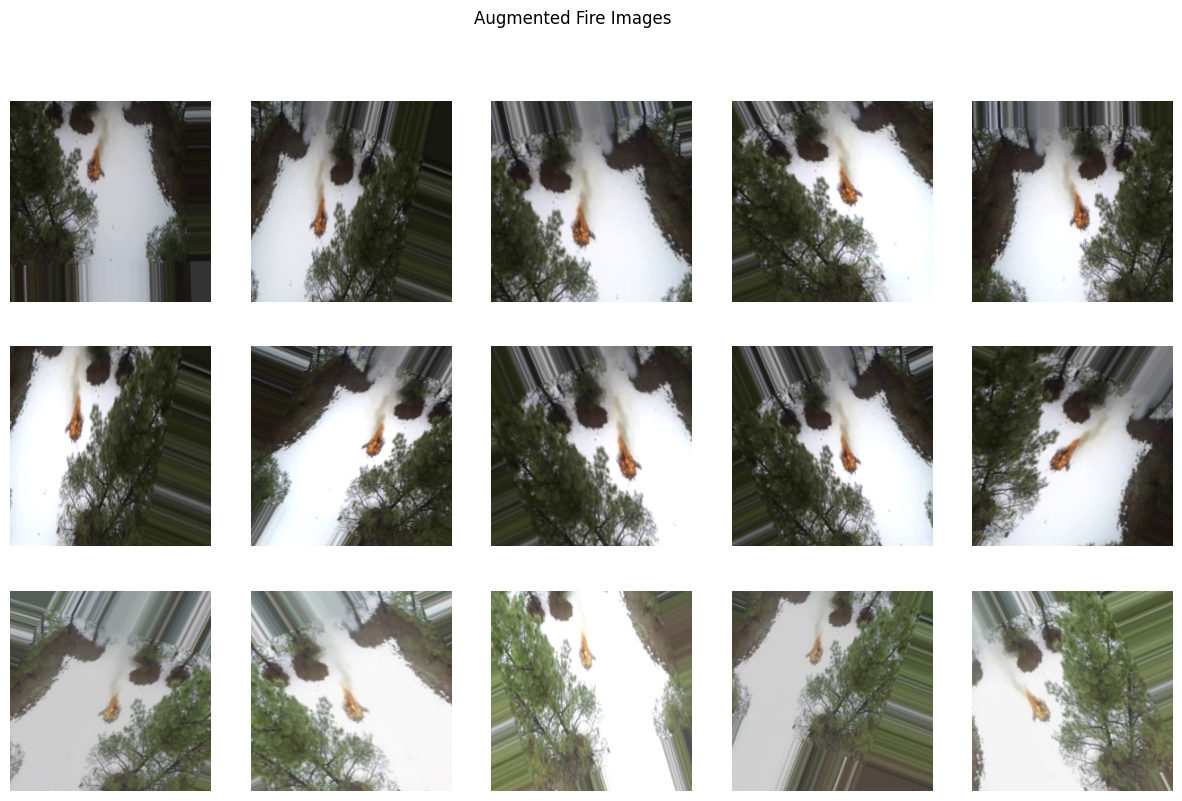

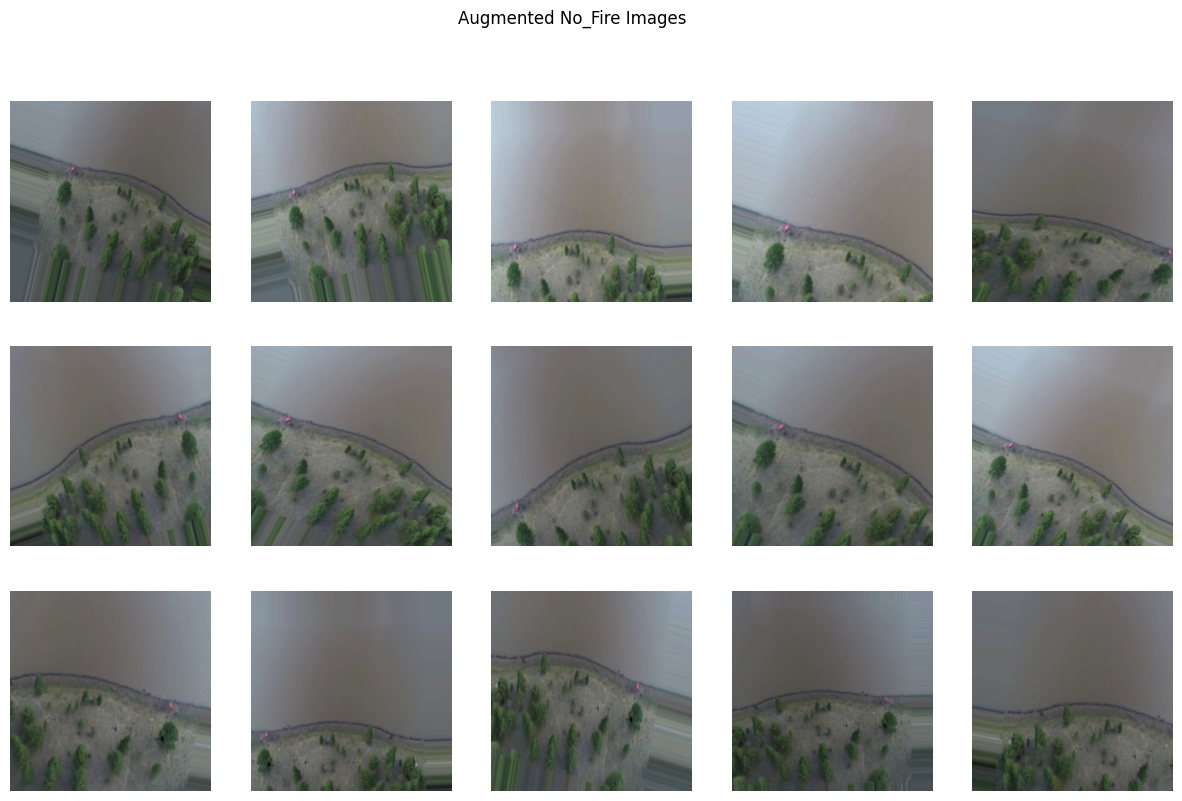

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directories for Fire and No_Fire images
fire_dir = 'Training/Fire'
no_fire_dir = 'Training/No_Fire'

# Data augmentation setup
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Display augmented sample images from each class
def display_augmented_images(class_dir, class_name, num_images=3, augmentations=5):
    images = os.listdir(class_dir)[:num_images]
    plt.figure(figsize=(15, num_images * 3))
    
    for img_index, image_name in enumerate(images):
        img_path = os.path.join(class_dir, image_name)
        img = Image.open(img_path).resize((224, 224))
        img_array = np.expand_dims(np.array(img), axis=0)
        
        # Apply augmentations and display the images
        for aug_index, augmented_image in enumerate(datagen.flow(img_array, batch_size=1)):
            if aug_index >= augmentations:
                break
            plt.subplot(num_images, augmentations, img_index * augmentations + aug_index + 1)
            plt.imshow(augmented_image[0].astype('uint8'))
            plt.axis('off')
    
    plt.suptitle(f"Augmented {class_name} Images")
    plt.show()

# Display augmented images for Fire and No_Fire classes
display_augmented_images(fire_dir, 'Fire')
display_augmented_images(no_fire_dir, 'No_Fire')


In [24]:
# Load the ResNet50 model with ImageNet weights, excluding the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in ResNet50
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of ResNet50
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout layer for regularization
output = Dense(1, activation='sigmoid')(x)  # Binary output

model = Model(inputs=base_model.input, outputs=output)


In [25]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
import os
import shutil
import random

def create_random_non_overlapping_subsets(source_dir, train_dest_dir, test_dest_dir, class_names, train_limit=5000, test_limit=1000):
    os.makedirs(train_dest_dir, exist_ok=True)
    os.makedirs(test_dest_dir, exist_ok=True)

    for class_name in class_names:
        source_class_dir = os.path.join(source_dir, class_name)
        train_class_dir = os.path.join(train_dest_dir, class_name)
        test_class_dir = os.path.join(test_dest_dir, class_name)

        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        # Get all images and shuffle
        images = os.listdir(source_class_dir)
        random.shuffle(images)

        # Select random images for test and training without overlap
        test_images = images[:test_limit]  # First 'test_limit' images for testing
        train_images = images[test_limit:test_limit + train_limit]  # Next 'train_limit' images for training

        # Copy test images
        for image in test_images:
            shutil.copy(os.path.join(source_class_dir, image), test_class_dir)

        # Copy training images
        for image in train_images:
            shutil.copy(os.path.join(source_class_dir, image), train_class_dir)

# Define source and destination directories
source_directory = 'Training'  # Original data directory
train_directory = 'Training_subset'  # Directory for the training subset
test_directory = 'Test_subset'  # Directory for the test subset
class_names = ['Fire', 'No_Fire']

create_random_non_overlapping_subsets(source_directory, train_directory, test_directory, class_names)


In [28]:
# Data generators for training and validation with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2  # 80% training, 20% validation split
)

train_generator = train_datagen.flow_from_directory(
    'Training_subset',  # Subset directory with 2,000 images per class
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    'Training_subset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [29]:
# Test Data Generator (No Augmentation)
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    'Test_subset',  # Path to test directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 2000 images belonging to 2 classes.


In [30]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)


Epoch 1/10
250/250 [==============================] - 156s 613ms/step - loss: 0.3609 - accuracy: 0.8771 - val_loss: 0.1888 - val_accuracy: 0.9420
Epoch 2/10
250/250 [==============================] - 92s 368ms/step - loss: 0.2612 - accuracy: 0.9014 - val_loss: 0.1439 - val_accuracy: 0.9632
Epoch 3/10
250/250 [==============================] - 90s 358ms/step - loss: 0.2427 - accuracy: 0.9082 - val_loss: 0.1201 - val_accuracy: 0.9632
Epoch 4/10
250/250 [==============================] - 90s 361ms/step - loss: 0.2304 - accuracy: 0.9160 - val_loss: 0.1172 - val_accuracy: 0.9617
Epoch 5/10
250/250 [==============================] - 90s 359ms/step - loss: 0.2246 - accuracy: 0.9162 - val_loss: 0.1175 - val_accuracy: 0.9647
Epoch 6/10
250/250 [==============================] - 91s 362ms/step - loss: 0.2256 - accuracy: 0.9160 - val_loss: 0.1120 - val_accuracy: 0.9783
Epoch 7/10
250/250 [==============================] - 90s 359ms/step - loss: 0.2183 - accuracy: 0.9172 - val_loss: 0.1400 - val_a

63/63 [==============================] - 4s 65ms/step - loss: 0.1770 - accuracy: 0.9530
Test Accuracy: 95.30%
Test Loss: 0.1770


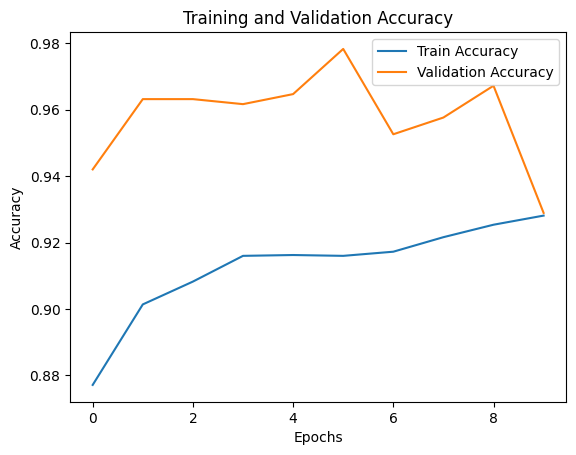

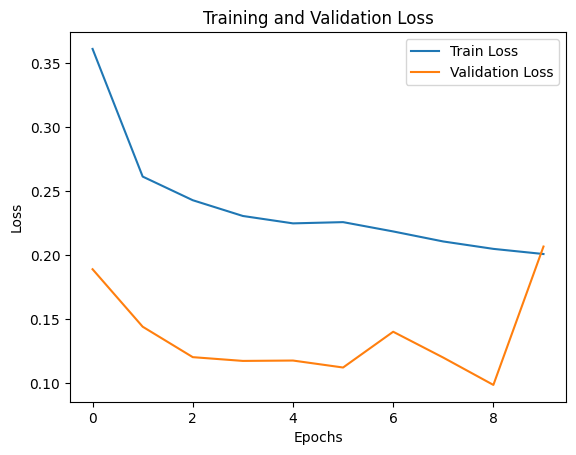

In [50]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Plot training and validation accuracy and loss
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

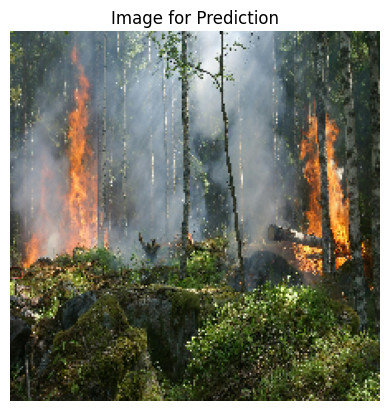

1/1 [==============================] - 0s 52ms/step
Fire detected


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img_path = r"C:\Users\Admin\Desktop\pexels-pixabay-51951.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Display the image
plt.imshow(image.array_to_img(img_array[0]))
plt.axis('off')
plt.title("Image for Prediction")
plt.show()

# Predict
prediction = model.predict(img_array)
if prediction[0] < 0.5:
    print("Fire detected")
else:
    print("No fire detected")

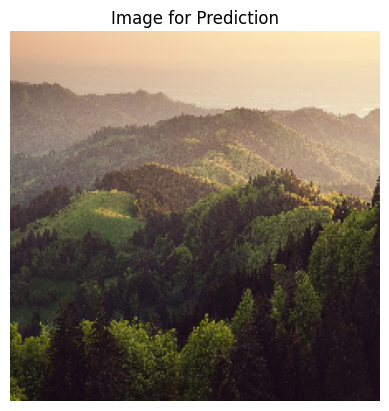

1/1 [==============================] - 0s 26ms/step
No fire detected


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img_path = r"C:\Users\Admin\Desktop\BlackForest-Germany-GettyImages-147180370.webp"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Display the image
plt.imshow(image.array_to_img(img_array[0]))
plt.axis('off')
plt.title("Image for Prediction")
plt.show()

# Predict
prediction = model.predict(img_array)
if prediction[0] < 0.5:
    print("Fire detected")
else:
    print("No fire detected")

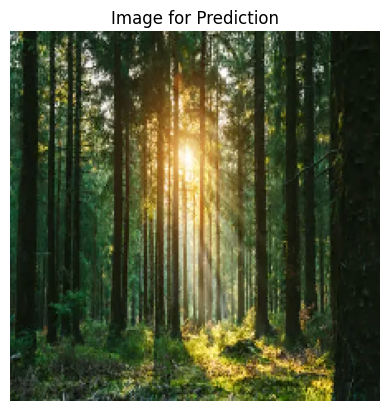

1/1 [==============================] - 0s 23ms/step
Fire detected


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img_path = r"C:\Users\Admin\Desktop\istockphoto-1419410282-612x612.webp"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Display the image
plt.imshow(image.array_to_img(img_array[0]))
plt.axis('off')
plt.title("Image for Prediction")
plt.show()

# Predict
prediction = model.predict(img_array)
if prediction[0] < 0.5:
    print("Fire detected")
else:
    print("No fire detected")

In [ ]:
from tensorflow.keras.models import load_model
#model.save("fire_detection_model.h5")
# Load the HDF5 model
#model = load_model("fire_detection_model.h5")